In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Измерения кристалла кремния с дислокациями                                                                                                                               
                                                                                                                                                                          
1. Трубка - Mo,режим 40 Кв, 30 мА (без монохроматора)                                                                                                                     
                                                                                                                                                                          
2. Геометрия эксперимента.                                                                                                                                                
Угол Брэгга - 10.66 (по факту 8.392)                                                                                                                                      
Угол детектора - 21.32                                                                                                                                                    
Углы поворота (для томографии) 0-185 с шагом 1 градус                                                                                                                     
                                                                                                                                                                          
3. Данные *.fit                                                                                                                                                           
20 кадров на поворот, экспозиция - 30 сек.                                                                                                                                
                                                                                                                                                                          
4. Темновой ток *.fit                                                                                                                                                     
1 кадр на поворот, экспозиция - 30 сек. (снимались после данных)                                                                                                          
                                                                                                                                                                          
Итого: 21 кадров на поворот, где 20 - данные и 1 темновой ток.



In [2]:
import os
import glob
import numpy as np
import pylab as plt
import h5py
import astra
from astropy.io import fits
import warnings
import ipywidgets
# from ipywidgets import interact, interactive, fixed, interact_manual
from skimage.restoration import denoise_nl_means
# import VarSIRT.vrecon


In [3]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

In [4]:
plt.gray()

In [5]:
import re
def natural_key(string_):
    """See http://www.codinghorror.com/blog/archives/001018.html"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

In [6]:
def read_fit(fit_path):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with fits.open(fit_path) as fit:
            tmp_data = fit[0].data.astype('uint16')
    return tmp_data

In [7]:
#lodad files and sort it ina natural way
data_dir = os.path.expanduser('/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/')
all_files = glob.glob(os.path.join(data_dir,'*.FITS'))
all_files = sorted(all_files, key=natural_key)
print(len(all_files))
all_files[0:10]

3880


['/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_35_28.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_36_07.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_36_45.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_37_23.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_38_01.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_38_39.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_39_17.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_39_54.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_40_33.FITS',
 '/diskmnt/a/makov/topo_tomo/Si/2018_03_05-07/data/IMG_2018_03_05_11_41_11.FITS']

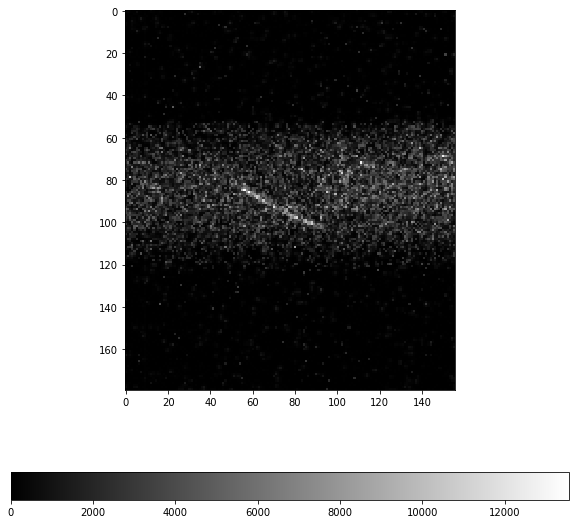

In [8]:
imcut=100
data_range = np.index_exp[220:400,744+imcut:1100-imcut]
zero_file = read_fit(all_files[0])[data_range]
plt.figure(figsize=(10,10))
plt.imshow(zero_file)
plt.colorbar(orientation='horizontal')
plt.show()

In [10]:
padding_size=zero_file.shape[1]//2
all_data = np.zeros(shape=(len(all_files), zero_file.shape[0], zero_file.shape[1]+2*padding_size), dtype='float32')
for i in log_progress(np.arange(len(all_files))):
    all_data[i,:,padding_size:-padding_size]=read_fit(all_files[i])[data_range]

A Jupyter Widget

In [11]:
#looking for numbers of free frames
free_numbers = np.argwhere(all_data.mean(axis=-1).mean(axis=-1)<50)
free_numbers = [x[0] for x in free_numbers]
print(len(free_numbers))

185


In [12]:
clear_frames = np.zeros(shape=(len(free_numbers), all_data.shape[1], all_data.shape[2]), dtype='float32')

In [13]:
std_frames = np.zeros_like(clear_frames)

In [14]:
#remove free frames from data images
current_frame = 0
for ifn, fn in enumerate(np.asarray(free_numbers)):
    zero_frame = all_data[fn]
#     tmp_frame = all_data[current_frame:fn].mean(axis=0)-zero_frame
    tmp_frame = np.percentile(all_data[current_frame:fn], 50, axis=0)-zero_frame
    tmp_frame[tmp_frame<0] = 0
    
    clear_frames[ifn] = tmp_frame
    
    tmp_frame_std = (all_data[current_frame:fn]-zero_frame).std(axis=0)
    tmp_frame_std[tmp_frame_std<1] = 1
    std_frames[ifn] = tmp_frame_std
    current_frame = fn+1

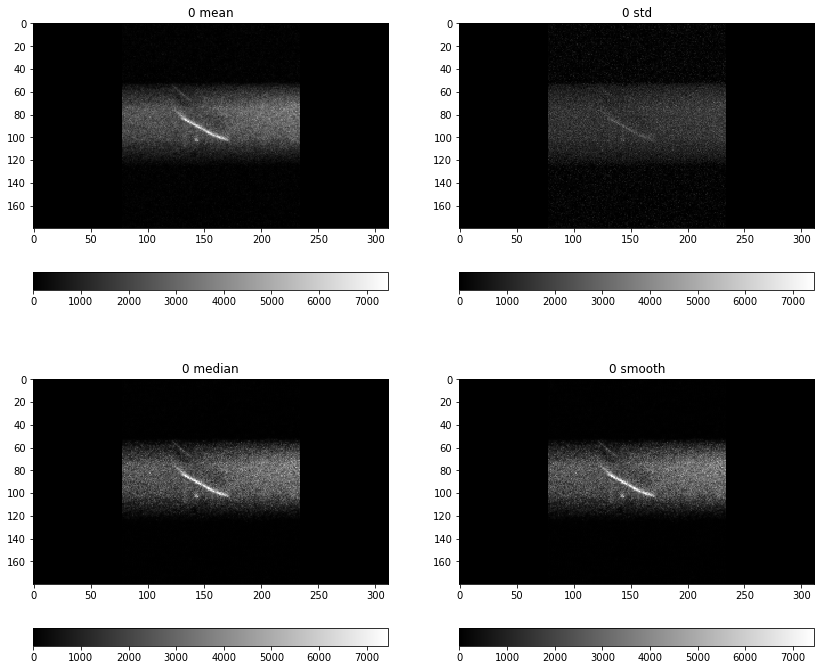

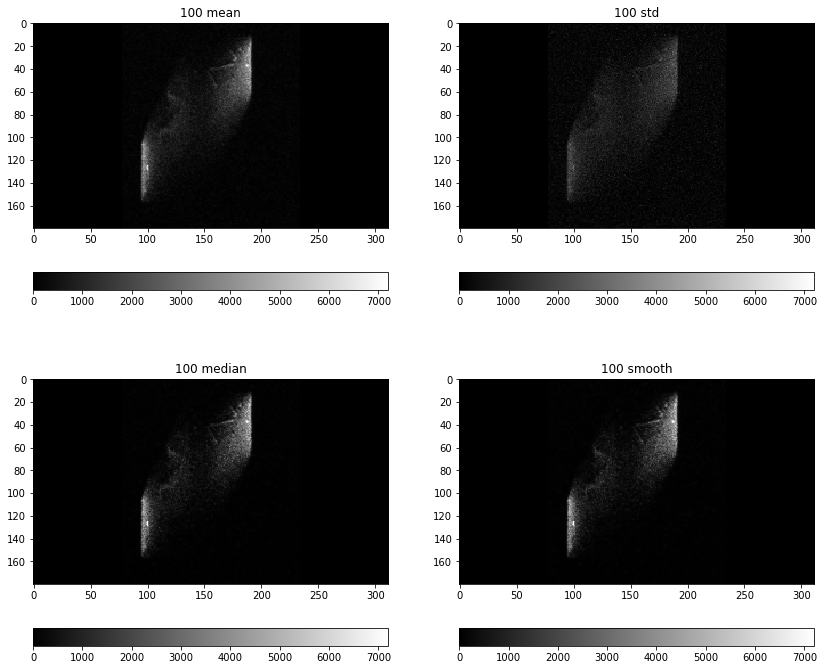

In [15]:
current_frame = 0
for ifn, fn in enumerate(np.asarray(free_numbers)):
    if ifn %100== 0:
        zero_frame = all_data[fn]
        t_data = all_data[current_frame:fn]-zero_frame
        
        t_s = np.sort(t_data, axis=0)
        tmp_frame_mean_e = np.percentile(t_data, 60, axis=0) #t_s[3:].mean(axis=0)
        
        tmp_frame_mean = t_data.mean(axis=0)
        tmp_frame_mean[tmp_frame_mean<1] = 1
        tmp_frame_std = t_data.std(axis=0)
        tmp_frame_std[tmp_frame_std<1] = 1
        tmp_frame_min = t_data.min(axis=0)
        tmp_frame_min[tmp_frame_min<1] = 1
        tmp_frame_smooth = np.percentile(t_data, 60, axis=0) 
        tmp_frame_smooth[tmp_frame_smooth<1] = 1
        
        vmax = np.max(tmp_frame_mean)
        plt.figure(figsize=(14,12))
        plt.subplot(221)
        plt.title(str(ifn) + ' mean')
        plt.imshow(tmp_frame_mean, vmin=0, vmax=vmax)
        plt.colorbar(orientation='horizontal')
        plt.subplot(222)
        plt.title(str(ifn) + ' std')
        plt.imshow(tmp_frame_std, vmin=0, vmax=vmax)
        plt.colorbar(orientation='horizontal')
        plt.subplot(223)
        plt.title(str(ifn) + ' median')
        plt.imshow(tmp_frame_mean_e, vmin=0, vmax=vmax)
        plt.colorbar(orientation='horizontal')
        plt.subplot(224)
        plt.title(str(ifn) + ' smooth')
        plt.imshow(tmp_frame_smooth, vmin=0, vmax=vmax)
        plt.colorbar(orientation='horizontal')
        plt.show()
        
#         plt.figure(figsize=(7,5))
#         for i in range(1,10):
# #             plt.subplot(220+i)
#             x,y = np.histogram(t_data[:, 100:102,100+10*i:100+10*i+2], bins=10)
#             plt.plot(y[1:], x,label=i)
#         plt.legend()
#         plt.grid()
#         plt.show()
    current_frame = fn+1

In [16]:
t_data.shape

(20, 180, 312)

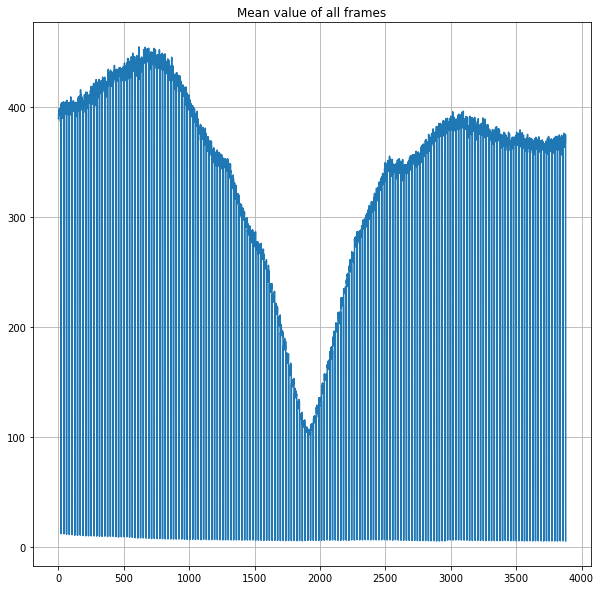

In [17]:
plt.figure(figsize=(10,10))
plt.plot(all_data[:].mean(axis=-1).mean(axis=-1))
plt.grid()
plt.title('Mean value of all frames')
plt.show()

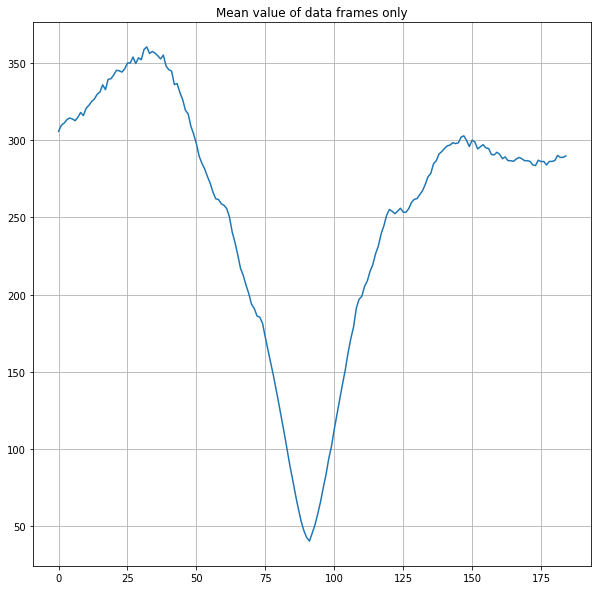

In [18]:
plt.figure(figsize=(10,10))
plt.plot(clear_frames[:].mean(axis=-1).mean(axis=-1))
plt.grid()
plt.title('Mean value of data frames only')
plt.show()

In [19]:
def show_array(data3d, axis_numb=0, k=0.7):
    vmax = data3d.max()
    def show_slice(i):
        plt.figure(figsize=(10,10))
        plt.imshow(local_data.take(i,axis=axis_numb),vmin=0, vmax=vmax*k)
        plt.colorbar(orientation='horizontal')
        plt.show()
    
    local_data = data3d
    ipywidgets.interact(show_slice, i=(0,data3d.shape[axis_numb]-1))

In [20]:
show_array(clear_frames)

A Jupyter Widget

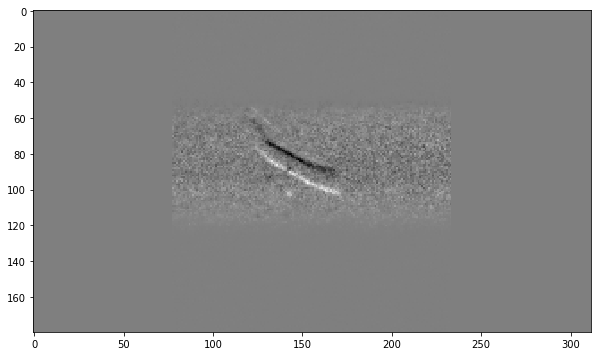

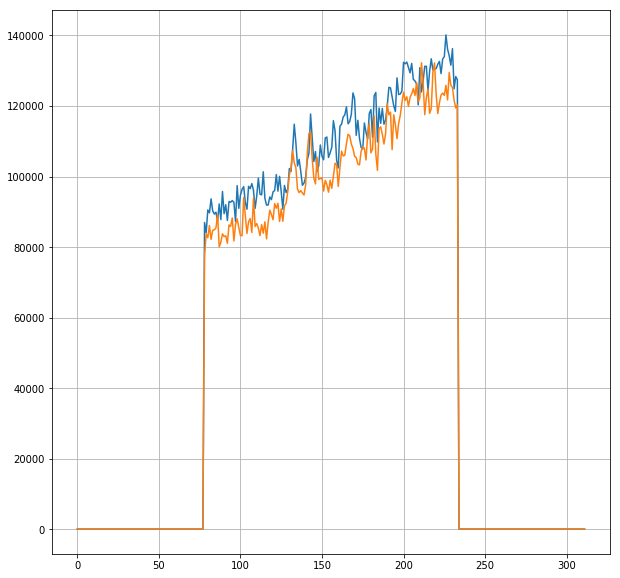

In [21]:
#adjusting frame horizontal borders
shift = 0
plt.figure(figsize=(10,10))
plt.imshow(np.roll(clear_frames[0],shift,1)-np.roll(np.fliplr(clear_frames[180]), - shift,1))
plt.show()

plt.figure(figsize=(10,10))
plt.plot(np.roll(clear_frames[0],shift,1).sum(axis=0))
plt.plot(np.roll(np.fliplr(clear_frames[180]), -shift ,1).sum(axis=0))
plt.grid()
plt.show()

In [22]:
from scipy.io import matlab

In [24]:
matlab.savemat('clear_frames.mat', {'frames': clear_frames})

In [ ]:
angles = np.arange(len(clear_frames))*1.0  # Angles step = 1 deg   

In [ ]:
import numpy as np
import os
import pylab as plt

def calculateNonNegative(x):
    res = np.zeros_like(x)
    res = -1.0 * x[x < 0]
    res = np.sign(res)       
    return np.sum(res)

def compute_regularization(x, reg_params):
    res_linear = 0.0
    res_exp = 0.0
    res_l1 = 0.0
    res_l2 = 0.0
    res_l1_grad = 0.0
    res_l2_grad = 0.0

    if reg_params[1] >= 0.000001:
        res_linear = np.zeros_like(x)
        res_linear[x < 0] = x[x < 0]
        res_linear = -1. * np.sum(res_linear)

    if reg_params[2] >= 0.000001:
        res_exp = np.zeros_like(x)
        res_exp[x < 0] = x[x < 0] 
        res_exp = np.sum(res_exp ** 2)

    if reg_params[3] >= 0.000001:
        res_l1 = np.sum(np.abs(x))

    if reg_params[4] >= 0.000001:
        res_l2 = np.sum(x ** 2)

    if reg_params[5] >= 0.000001:
        res_l1_grad = np.zeros_like(x)
        res_l1_grad[:-1, :] = np.abs(np.diff(x, axis=0))
        res_l1_grad[:, :-1] += np.abs(np.diff(x, axis=1))
        res_l1_grad = np.sum(res_l1_grad)
        
    if reg_params[6] >= 0.000001:
        res_l2_grad = np.zeros_like(x)
        res_l2_grad[:-1, :] = np.diff(x, axis=0) ** 2
        res_l2_grad[:, :-1] += np.diff(x, axis=1) ** 2
        res_l2_grad = np.sum(res_l2_grad)
    
    sx = x.shape[0]
    k = sx / calculateNonNegative(x)
    res_linear *= k
    res_exp *= k
    
    res_l1 /= sx
    res_l1_grad /= sx
    res_l2 /= sx
    res_l2_grad /= sx

    res_l2 = sx * np.sqrt(res_l2 / sx)
    res_l2_grad = sx * np.sqrt(res_l2_grad / sx)
    res_exp = sx * np.sqrt(res_exp / sx)
    
    res = np.zeros_like(x)
    if not np.isclose(reg_params[1],0):
        res += res_linear * reg_params[1]
    if not np.isclose(reg_params[2],0):
        res += res_exp * reg_params[2]
    if not np.isclose(reg_params[3],0):
        res += res_l1 * reg_params[3]
    if not np.isclose(reg_params[4],0):
        res += res_l2 * reg_params[4]
    if not np.isclose(reg_params[5],0):
        res += res_l1_grad * reg_params[5]
    if not np.isclose(reg_params[6],0):
        res += res_l2_grad * reg_params[6]
        
    return res

def compute_functional(D_r, D_g, D_r_grad, x_k, alpha, reg_parameters):
    k = 1.0 / (D_r.size)
    f = k * np.sum((D_r + alpha * D_r_grad) ** 2)
    f = np.sqrt(f) * (1.0 - reg_parameters[0])
    if not np.isclose(reg_parameters[0],0):
        f += reg_parameters[0] * compute_regularization(x_k + alpha * D_g, reg_parameters)
    return f

def normilize_gr(g, grad_buffer, reg_params_1, reg_params_2):
    norm1 = 1.0 / np.sum(np.abs(grad_buffer))
    if norm1 > 1e+6:
        norm1 = 1.0
    g += grad_buffer * (reg_params_1 * reg_params_2 * norm1)
    return g

def regularize_gradient(x, g, reg_params):
    norm = 1.0 / np.sum(np.abs(g))
    if norm < 1e+6:
        g *= norm

    if reg_params[0] < 0.000001:
        return g

    g = g * (1. - reg_params[0])
    
    if np.abs(reg_params[1]) > 0.000001:
        grad_buffer = np.zeros_like(g)
        grad_buffer[x < 0] = -1. * [x < 0]
        g = normilize_gr(g, grad_buffer, reg_params[0], reg_params[1])
    if np.abs(reg_params[2]) > 0.000001:
        grad_buffer = np.zeros_like(g)
        grad_buffer[x < 0] = x[x < 0]
        g = normilize_gr(g, grad_buffer, reg_params[0], reg_params[2])
    if np.abs(reg_params[3]) > 0.000001:
        grad_buffer = np.zeros_like(g)
        grad_buffer = np.sign(x)
        grad_buffer[grad_buffer == 0.0] = 1.0
        g = normilize_gr(g, grad_buffer, reg_params[0], reg_params[3])
    if np.abs(reg_params[4]) > 0.000001:
        grad_buffer = np.copy(x)
        g = normilize_gr(g, grad_buffer, reg_params[0], reg_params[4])
    if np.abs(reg_params[5]) > 0.000001:
        grad_buffer = np.zeros_like(g)
        g_0 = np.diff(x, axis=0)
        g_1 = np.diff(x, axis=1)
        mask_0 = g_0 == 0.0
        mask_1 = g_1 == 0.0
        g_0 [mask_0] = -1.0
        grad_buffer[:-1, :] = np.sign(-g_0)
        g_0 [mask_0] = 1.0
        grad_buffer[1:, :] += np.sign(g_0)
        g_1 [mask_1] = -1.0
        grad_buffer[:, :-1] += np.sign(-g_1)
        g_1 [mask_1] = 1.0
        grad_buffer[:, 1:] += np.sign(g_1)
        g = normilize_gr(g, grad_buffer, reg_params[0], reg_params[5])
    if np.abs(reg_params[6]) > 0.000001:
        grad_buffer = np.zeros_like(g)
        g_0 = np.diff(x, axis=0)
        g_1 = np.diff(x, axis=1)
        grad_buffer[:-1, :] = -g_0
        grad_buffer[1:, :] += g_0
        grad_buffer[:, :-1] -= g_1
        grad_buffer[:, 1:] += g_1
        g = normilize_gr(g, grad_buffer, reg_params[0], reg_params[6])

    return g

def compute_gradient(A, sino, D, x, reg_parameters):
    D_r = D * (A * x).reshape(sino.shape) - sino
    D_g = (A.T * (D_r * D)).reshape(x.shape)
    D_g = regularize_gradient(x, D_g, reg_parameters)
    D_r_grad = D * (A * D_g).reshape(sino.shape)
    return D_r, D_g, D_r_grad

def ternary_search(D_r, D_g, D_r_grad, x_k, left, right, reg_parameters):
    while right - left > np.abs(right+left)/2./10 :  #todo: check it
        a = (left * 2 + right) / 3
        b = (left + right * 2) / 3
        
        f1 = compute_functional(D_r, D_g, D_r_grad, x_k, a, reg_parameters)
        f2 = compute_functional(D_r, D_g, D_r_grad, x_k, b, reg_parameters)

        if f1 < f2:
            right = b
        else:
            left = a

    return (left + right) / 2

def iterate(A, sino, x0, D=None, reg_parameters=None, n_it=100):
    if D is None:
        prefix = 'cg'
        D = np.ones_like(sino, dtype='float32')
    else:
        prefix = 'vcg'
    reg_param = np.zeros(7)
    if reg_parameters is not None:
        if 'total' in reg_parameters:
            reg_param[0] = reg_parameters['total']
        if 'lin' in reg_parameters:
            reg_param[1] = reg_parameters['lin']
        if 'exp' in reg_parameters:
            reg_param[2] = reg_parameters['exp']
        if 'l1' in reg_parameters:
            reg_param[3] = reg_parameters['l1']
        if 'l2' in reg_parameters:
            reg_param[4] = reg_parameters['l2']
        if 'l1_grad' in reg_parameters:
            reg_param[5] = reg_parameters['l1_grad']
        if 'l2_grad' in reg_parameters:
            reg_param[6] = reg_parameters['l2_grad']
        prefix+='_reg'
     
    sino_d = sino.copy()
    sino_d *= D

    x_k = x0.copy()
    en_ar = []
    x_k_ar = []
    al_ar = []
    it_count = n_it
    alpha = -1e6

    for it in log_progress(range(0, n_it)):
        D_r, D_g, D_r_grad = compute_gradient(A, sino_d, D, x_k, reg_param) 

        if compute_functional(D_r, D_g, D_r_grad, x_k, 0.0, reg_param) < 1.e-5:
            it_count = it - 1
            break

        alpha = ternary_search(D_r, D_g, D_r_grad, x_k, alpha*1.3,  0, reg_param)
        x_k = x_k + alpha * D_g
        
        eng = np.sum(((A * x_k).reshape(sino.shape) - sino) ** 2)
        en_ar.append(np.sqrt(eng))
#         x_k_ar.append(x_k)
        al_ar.append(alpha)
        
        #if it % 10 == 0 or it < 20:
        #  plt.imsave('{}_{:004}.png'.format(prefix, it), x_k, vmin=0, vmax=0.1, cmap='gray')

    return {'rec': x_k,
                    'iter': it_count,
                    'energy': en_ar,
#                     'x_k': x_k_ar,
                    'alpha': al_ar
                    }

def CG(A, sino, x0, reg_parameters=None, n_it=100):
    return iterate(A, sino, x0, None, reg_parameters, n_it)

def VCG(A, sino, x0, D, reg_parameters=None, n_it=100):
    return iterate(A, sino, x0, D, reg_parameters, n_it)
                    

In [ ]:
def build_geometry(sinogram, angles):
    astra_angles = angles.astype('float64')
    detector_size = sinogram.shape[-1]
    slices_number = sinogram.shape[0]

    rec_size = detector_size
    vol_geom = astra.create_vol_geom(rec_size, rec_size, slices_number)
    
    # We generate the same geometry as the circular one above.
    vectors = np.zeros((len(astra_angles), 12))
    alpha = -21.32/2*np.pi/180  #  define bragg angle
    for i in range(len(astra_angles)):
        # ray direction
        vectors[i,0] = np.sin(astra_angles[i])*np.cos(alpha)
        vectors[i,1] = -np.cos(astra_angles[i])*np.cos(alpha)
        vectors[i,2] = np.sin(alpha)

        # center of detector
        vectors[i,3:6] = 0

        # vector from detector pixel (0,0) to (0,1)
        vectors[i,6] = np.cos(astra_angles[i])
        vectors[i,7] = np.sin(astra_angles[i])
        vectors[i,8] = 0;

        # vector from detector pixel (0,0) to (1,0)
        vectors[i,9] = 0
        vectors[i,10] = 0
        vectors[i,11] = 1

    # Parameters: #rows, #columns, vectors
    proj_geom = astra.create_proj_geom('parallel3d_vec', slices_number, detector_size, vectors)
    return proj_geom, vol_geom

def astra_topotomo3d(sinogram, angles, n_iters=10):
    proj_geom, vol_geom = build_geometry(sinogram, angles)

    sinogram_id = astra.data3d.create('-sino', proj_geom, data=sinogram)
    
    # Create a data object for the reconstruction
    rec_id = astra.data3d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('CGLS3D_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id, n_iters)

    # Get the result
    rec = astra.data3d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data3d.delete(rec_id)
    astra.data3d.delete(sinogram_id)
    astra.clear()
    return rec

def vcg(sinogram, angles, x0=None, D=None, reg_params=None, n_iters=10):
    proj_geom, vol_geom = build_geometry(sinogram, angles)
    proj_id = astra.create_projector('cuda3d', proj_geom, vol_geom)
    W = astra.OpTomo(proj_id)
    detector_size = sinogram.shape[-1]
    slices_number = sinogram.shape[0]
    if x0 is None:
        x0 = np.zeros((slices_number,detector_size,detector_size), dtype='float32')
    rec = iterate(W, sinogram, x0, D, reg_parameters=reg_params, n_it=n_iters)
    return rec

In [ ]:
#normalizing sinogram
# data = clear_frames/np.expand_dims(np.expand_dims(clear_frames.mean(axis=-1).mean(axis=-1),-1),-1)
# data = data[::2]
data = clear_frames.copy()
data /= np.expand_dims(np.expand_dims(data.mean(axis=-1).mean(axis=-1),-1),-1)
data = np.log(1.+data)
data /= np.expand_dims(np.expand_dims(data.mean(axis=-1).mean(axis=-1),-1),-1)


In [ ]:
show_array(data,1)

In [ ]:
#some fast magic with axis
s1 = np.require(data[:,:,:].swapaxes(0,1),dtype=np.float32, requirements=['C'])

In [ ]:
D = std_frames.swapaxes(0,1).copy()

In [ ]:
show_array(10./(10+D),1, 0.05)

In [ ]:
np.percentile(D.ravel(),1)

In [ ]:
def show_slice(data, axis_numb):
    img = data.take(data.shape[axis_numb]//2, axis=axis_numb)
    vmax = np.percentile(img.ravel(), 99)
    plt.figure(figsize=(10,10))
    plt.imshow(img, vmin=0, vmax=vmax)
    plt.colorbar(orientation='horizontal')

In [ ]:
#trick with sinogram normalization
# rec_3d = astra_topotomo3d(np.log(1.+s1), angles*np.pi/180)
rec_3d = astra_topotomo3d(s1, angles*np.pi/180,100)

In [ ]:
show_slice(rec_3d,0)

In [ ]:
show_array(rec_3d,0)

In [ ]:
show_slice(rec_3d,2)

In [ ]:
show_array(rec_3d, 0,0.3)

In [ ]:
# show_array(rec_3d,0,0.1)

In [ ]:
mask = D>600

In [ ]:
show_slice(rec_3d_v['rec'],1)

In [ ]:
!mkdir -p pics

In [ ]:
alpha = []
energy = []
for i in range(0,1000):
    print(i*10)
    if i == 0:
        x0 = None
    else:
        x0 = rec_3d_v['rec'] 
        
    rec_3d_v = vcg(s1, angles*np.pi/180, x0, 1.+s1, [10.,0.,0.,0.,1.,1.,0.], 10) # [1.,0.,0.,0.,1.,1.,0.],
    
    alpha.extend(rec_3d_v['alpha'])
    plt.figure(figsize=(10,5))
    plt.semilogy(-np.asarray(alpha))
    plt.grid()
    plt.show()
    
    energy.extend(rec_3d_v['energy'])
    plt.figure(figsize=(10,5))
    plt.semilogy(np.asarray(energy))
    plt.grid()
    plt.show()
    
    show_slice(rec_3d_v['rec'],0)
    plt.savefig('pics/0_{}.png'.format(i))
    plt.show()
    show_slice(rec_3d_v['rec'],2)
    plt.savefig('pics/2_{}.png'.format(i))
    plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.semilogy(-np.asarray(alpha))
plt.grid()

In [ ]:
plt.figure(figsize=(10,5))
plt.semilogy(np.asarray(energy))
plt.grid()

In [ ]:
show_array(rec_3d_v['rec'],1,0.5)

In [ ]:
# rec_3d_smooth = denoise_nl_means(rec_3d,2,1)

In [ ]:
# show_array(rec_3d_smooth,0)

In [ ]:
# sl = rec_3d[rec_3d.shape[0]/3]
# mask = np.zeros_like(sl)
# X,Y = meshgrid(np.arange(mask.shape[0]),np.arange(mask.shape[1]))
# X = X-mask.shape[0]/2
# Y = Y-mask.shape[1]/2
# mask = (X*X+Y*Y)**0.5<(mask.shape[0]/2)-3
# rec_3d_masked = rec_3d*mask 

In [ ]:
# show_array(rec_3d_masked)

In [ ]:
# data_file_parts = os.path.join(data_dir,'result.h5')
# out_file = '{}_reconstruction.h5'.format(''.join(data_file_parts[:-1]))

out_file = os.path.join(data_dir,'result.h5')
print(out_file)
with h5py.File(out_file,'w') as h5f:
    h5f.create_dataset('Result', data=rec_3d[:,padding_size:-padding_size,padding_size:-padding_size],
                       dtype=np.float32)
#     h5f.create_dataset('Result', data=rec_3d_v['rec'], dtype=np.float32)

In [ ]:
def save_amira(result_file):
    """
    Функция сохраняет реконструированные слои в формате Amira raw file

    Inputs:
        data_path - путь к директории, где находиться файл res_tomo.hdf5 в формате HDF5
            в этом файде должен быть раздел (node) /Results в котором в виде 3D массива
            записаны реконструированный объём
    Outputs:
        Файлы amira.raw и tomo.hx. Если файлы уже существуют, то они перезаписываются.
        Тип данных: float32 little endian
    """
    data_path = os.path.dirname(result_file)
    with open(os.path.join(data_path, 'amira.raw'), 'wb') as amira_file:
        with h5py.File(result_file, 'r') as h5f:
            x = h5f['Result']
            for i in range(x.shape[0]):
                np.array(x[i, :, :]).tofile(amira_file)

            file_shape = x.shape

            with open(os.path.join(data_path, 'tomo.hx'), 'w') as af:
                af.write('# Amira Script\n')
                af.write('remove -all\n')
                af.write(r'[ load -raw ${SCRIPTDIR}/amira.raw little xfastest float 1 '+
                         str(file_shape[1])+' '+str(file_shape[2])+' '+str(file_shape[0])+
                         ' 0 '+str(file_shape[1]-1)+' 0 '+str(file_shape[2]-1)+' 0 '+str(file_shape[0]-1)+
                         ' ] setLabel tomo.raw\n')

In [ ]:
save_amira(out_file)